# pip -q install matplotlib


Understand how PyTorch tracks gradients.


In research papers, you'll see complex loss functions (e.g., GAN losses, Variational Autoencoder KL-divergence). You need to know exactly when a gradient is being calculated and when it is being "cut off."

 Objective:
1. Understand the "Computational Graph."
2. Implement a manual gradient descent loop.
3. Understand `detach()` and `with torch.no_grad()`.

## Problem 1: The Manual Neuron
You are not allowed to use `nn.Linear` or `nn.MSELoss`. You must build a single neuron ($y = wx + b$) and train it to fit the data using raw tensors.

Implement the full training loop (100 epochs) and visualize it. 

1.  **The Loop:** Run the training for 100 iterations.
2.  **The Plot:** 
    *   Plot the initial data points (`plt.scatter`).
    *   Every 20 epochs, calculate `y_pred` and plot the line (`plt.plot`).
    *   **Crucial:** When plotting, you must use `y_pred.detach().numpy()`. 

**Why `.detach()`?**
If you try to pass a tensor that has `requires_grad=True` to Matplotlib, it will throw an error. Matplotlib doesn't know how to handle "math history." `.detach()` creates a copy of the tensor that is "disconnected" from the graph.

```python
import torch
import matplotlib.pyplot as plt

# 1. Setup
x = torch.linspace(0, 10, 100)
y_true = 3 * x + 2 + torch.randn(100)
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
alpha = 0.01

plt.figure(figsize=(10, 6))
plt.scatter(x, y_true, color='gray', alpha=0.5, label='Data')

# 2. THE LOOP
for epoch in range(101):
    # --- YOUR CODE HERE ---
    # Forward pass
    # Loss calculation
    # Backward pass
    # Update (Inside no_grad)
    # Zero gradients
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f}")
        plt.plot(x, y_pred.detach(), label=f'Epoch {epoch}')

plt.legend()
plt.show()
```

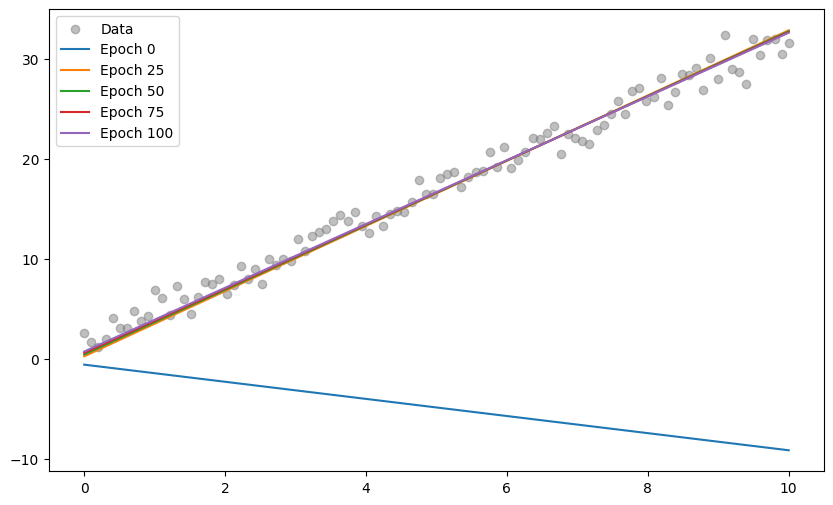

In [17]:
import torch
import matplotlib.pyplot as plt

# Setup
x = torch.linspace(0, 10, 100)
y_true = 3 * x + 2 + torch.randn(100)
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
alpha = 0.01

plt.figure(figsize=(10, 6))
plt.scatter(x, y_true, color='gray', alpha=0.5, label='Data')

for epoch in range(101):
    # 1. Forward Pass 
    y_pred = w * x + b
    
    # 2. Loss calculation
    loss = torch.mean((y_true - y_pred) ** 2)

    # 3. Backward Pass 
    loss.backward()

    # 4. Parameters update (Inside no_grad)
    with torch.no_grad():
        w -= alpha * w.grad
        b -= alpha * b.grad
        
        # 5. Zero gradients
        w.grad.zero_()
        b.grad.zero_()
    
    if epoch % 25 == 0:
        plt.plot(x, y_pred.detach(), label=f'Epoch {epoch}')

plt.legend()
plt.show()

<details>
<summary>Post-Mortem (Problem 1)</summary>

#### 1. `zero_grad()` : Why does PyTorch accumulate?
**The Question:** What happens if you forget `w.grad.zero_()`?
**The Answer:** Your model will "explode" (Loss $\rightarrow$ Infinity/NaN).

**The First Principle:** PyTorch **adds** the new gradient to the old one. If the gradient in step 1 is `0.5` and step 2 is `0.5`, `w.grad` becomes `1.0`. By step 100, your gradient is massive.
*   **Why would PyTorch do this?** In research, we sometimes have huge models that don't fit on one GPU. We use **Gradient Accumulation**. We run 4 mini-batches, let the gradients "pile up," and *then* update the weight once. It’s a feature, not a bug—but you must control it.

#### 2. In-place (`-=`) vs. Out-of-place (`= -`)
**The Question:** What is the difference between `w = w - alpha * w.grad` and `w -= alpha * w.grad`?

*   **`w = w - ...` (Out-of-place):** This creates a **brand new tensor** in a new memory location. Because this new tensor was created by a math operation, PyTorch tries to track it. `w` is no longer a "leaf" (a starting variable); it's now a "result." This breaks the optimization loop.
*   **`w -= ...` (In-place):** This modifies the **existing numbers** in the same memory box. It keeps `w` as the same "leaf" tensor. 

**The Catch:** PyTorch **forbids** in-place operations on tensors that need gradients *unless* you are inside a `with torch.no_grad():` block. 

</details>

___

## Problem 2: Broken Chain (Computational Graph Visualization)

To implement research papers, you'll often need to "stop" gradients from flowing through certain parts of a network (e.g., in **GANs** or **RL**). We need to see the "hidden" graph.

### The Challenge:
We will use a tool called `torchviz` to see the graph, but first, you must predict what happens to the math.

**The Setup:**
```python
x = torch.tensor([1.0], requires_grad=True)
y = x**2
z = y**3
```

**Your Challenge:**
1.  **The Interruption:** Create a new variable `y_detached = y.detach()`. Now compute `z_new = y_detached ** 3`.
2.  **The Backward:** Call `z_new.backward()`. 
3.  **The Prediction:** What is `x.grad`? Is it `6` (the derivative of $x^6$ at $x=1$) or is it `None/0`?
4.  **The "Why":** Explain in your own words what `.detach()` did to the "Chain Rule."

In [19]:


x = torch.tensor([1.0], requires_grad=True)
y = x**2
z = y**3



y_detached = y.detach()
z_new = y_detached**3

try:
    z_new.backward()
    print(f"Gradient of x: {x.grad}")
except Exception as e:
    print(f"Error: {e}")

Error: element 0 of tensors does not require grad and does not have a grad_fn


<details>
<summary>Post-Mortem (Problem 2)</summary>

When you run that code, you will likely hit an error in your `try-except` block:
`RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn`

#### 1. Why did it fail?
When you call `y.detach()`, you are effectively telling PyTorch: *"Take the current value of y, but forget how we calculated it. From now on, y is just a constant number, not a part of a math equation."*

Because `y_detached` is a constant:
1.  `z_new = y_detached**3` also becomes a constant (it doesn't have a `grad_fn`).
2.  When you call `z_new.backward()`, PyTorch says: *"I have no map to follow. There are no variables to calculate gradients for."*

#### 2. Why is this useful in Research?
Imagine you are training a **GAN** (Generative Adversarial Network). 
*   You have a **Generator** and a **Discriminator**. 
*   When training the Discriminator, you want to show it images from the Generator, but you **don't** want to update the Generator's weights yet.
*   You use `.detach()` on the generated images to "break the chain" so gradients only flow through the Discriminator.


</details>


___

## Problem 3: Manual "Backprop" vs. Autograd


**The Setup:**
Take the function: $f(x) = \sin(x^2)$
Let $x = 2.0$.

**Your Challenge:**
1.  **Autograd Way:** Use PyTorch to find the gradient of $f$ with respect to $x$.
2.  **Manual Way:** 
    *   Use the Chain Rule: $\frac{df}{dx} = \cos(x^2) \cdot 2x$.
    *   Calculate this value manually in Python.
3.  **Verification:** Compare the two values.

In [23]:
import torch

x = torch.tensor(2.0, requires_grad=True)
#function
f = torch.sin(x ** 2)

# use pytorch to find gradient
f.backward()
print(f"gradient of f using pytorch at x = 2.0: {x.grad}")

#using manual differentiation 
df = 2 * x * torch.cos(x ** 2)
print(f"gradient of f using manual differentiation at x = 2.0: {df}")

gradient of f using pytorch at x = 2.0: -2.614574432373047
gradient of f using manual differentiation at x = 2.0: -2.614574432373047


<details>
<summary>Post-Mortem (Problem 3)</summary>

The values match. In research, this is your "Audit" tool. If you ever implement a custom operation (like a new activation function) and your model isn't learning, you should manually calculate the derivative and compare it to PyTorch's `grad` to ensure there isn't a bug in the math.
</details>